Systematic Uncertainty Modelling
===

In the `Neural_Likelihood_Ratio_Estimation.ipynb` notebook, we left out the nuisance parameter piece of the parameterized density ratio decomposition:

$$g_c(x|\alpha) = \frac{p_c(x|\alpha)}{p_c(x)} = \prod_m \frac{p_c(x|\alpha_m^{eval})}{p_c(x)}$$

where the second equality assumes that the effect of various sources of uncertainty in the model can be factorized. This is another density ratio estimation problem, but instead of training m $\alpha-$parameterized NNs, we use a HistFactory-style interpolation generalized to a per-event formulation:

$$\frac{p_c(x|\alpha_m^{eval})}{p_c(x)} = \begin{cases}
    \left(\frac{p_c(x|\alpha_m^+)}{p_c(x)}\right)^{\alpha_m^\text{eval}}& \alpha_m^\text{eval}>1\\
    1+\sum_{n=1}^6c_n\cdot (\alpha_m^\text{eval})^n& -1\leq\alpha_m^\text{eval}\leq 1\\
    \left(\frac{p_c(x|\alpha_m^-)}{p_c(x)}\right)^{-\alpha_m^\text{eval}}& \alpha_m^\text{eval}<-1\\
    \end{cases}$$

where $\alpha=\{\alpha_m^{eval}\}$ and for each nuisance parameter $m$, we have three simulation models - $p_c(x), p_c(x|\alpha_m^+), p_c(x|\alpha_m^-)$. Naturally, this still requires NNs to estimate the density ratios:

$$\frac{p_c(x|\alpha_m^+)}{p_c(x)} \, , \frac{p_c(x|\alpha_m^-)}{p_c(x)}$$

This is done for each systematic uncertainty and for each channel $c$ to build the final parameterized model, 

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\sum_c G_c(\alpha) \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot G_c(\alpha) \cdot \nu_c \cdot g_c(x|\alpha) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)}$$

**The workflow presented in this tutorial lacks nuisance paramter modelling. Will be adding soon!**

The full workflow for building $\mu, \alpha-$parameterized density ratios is represented in the flowchart below:

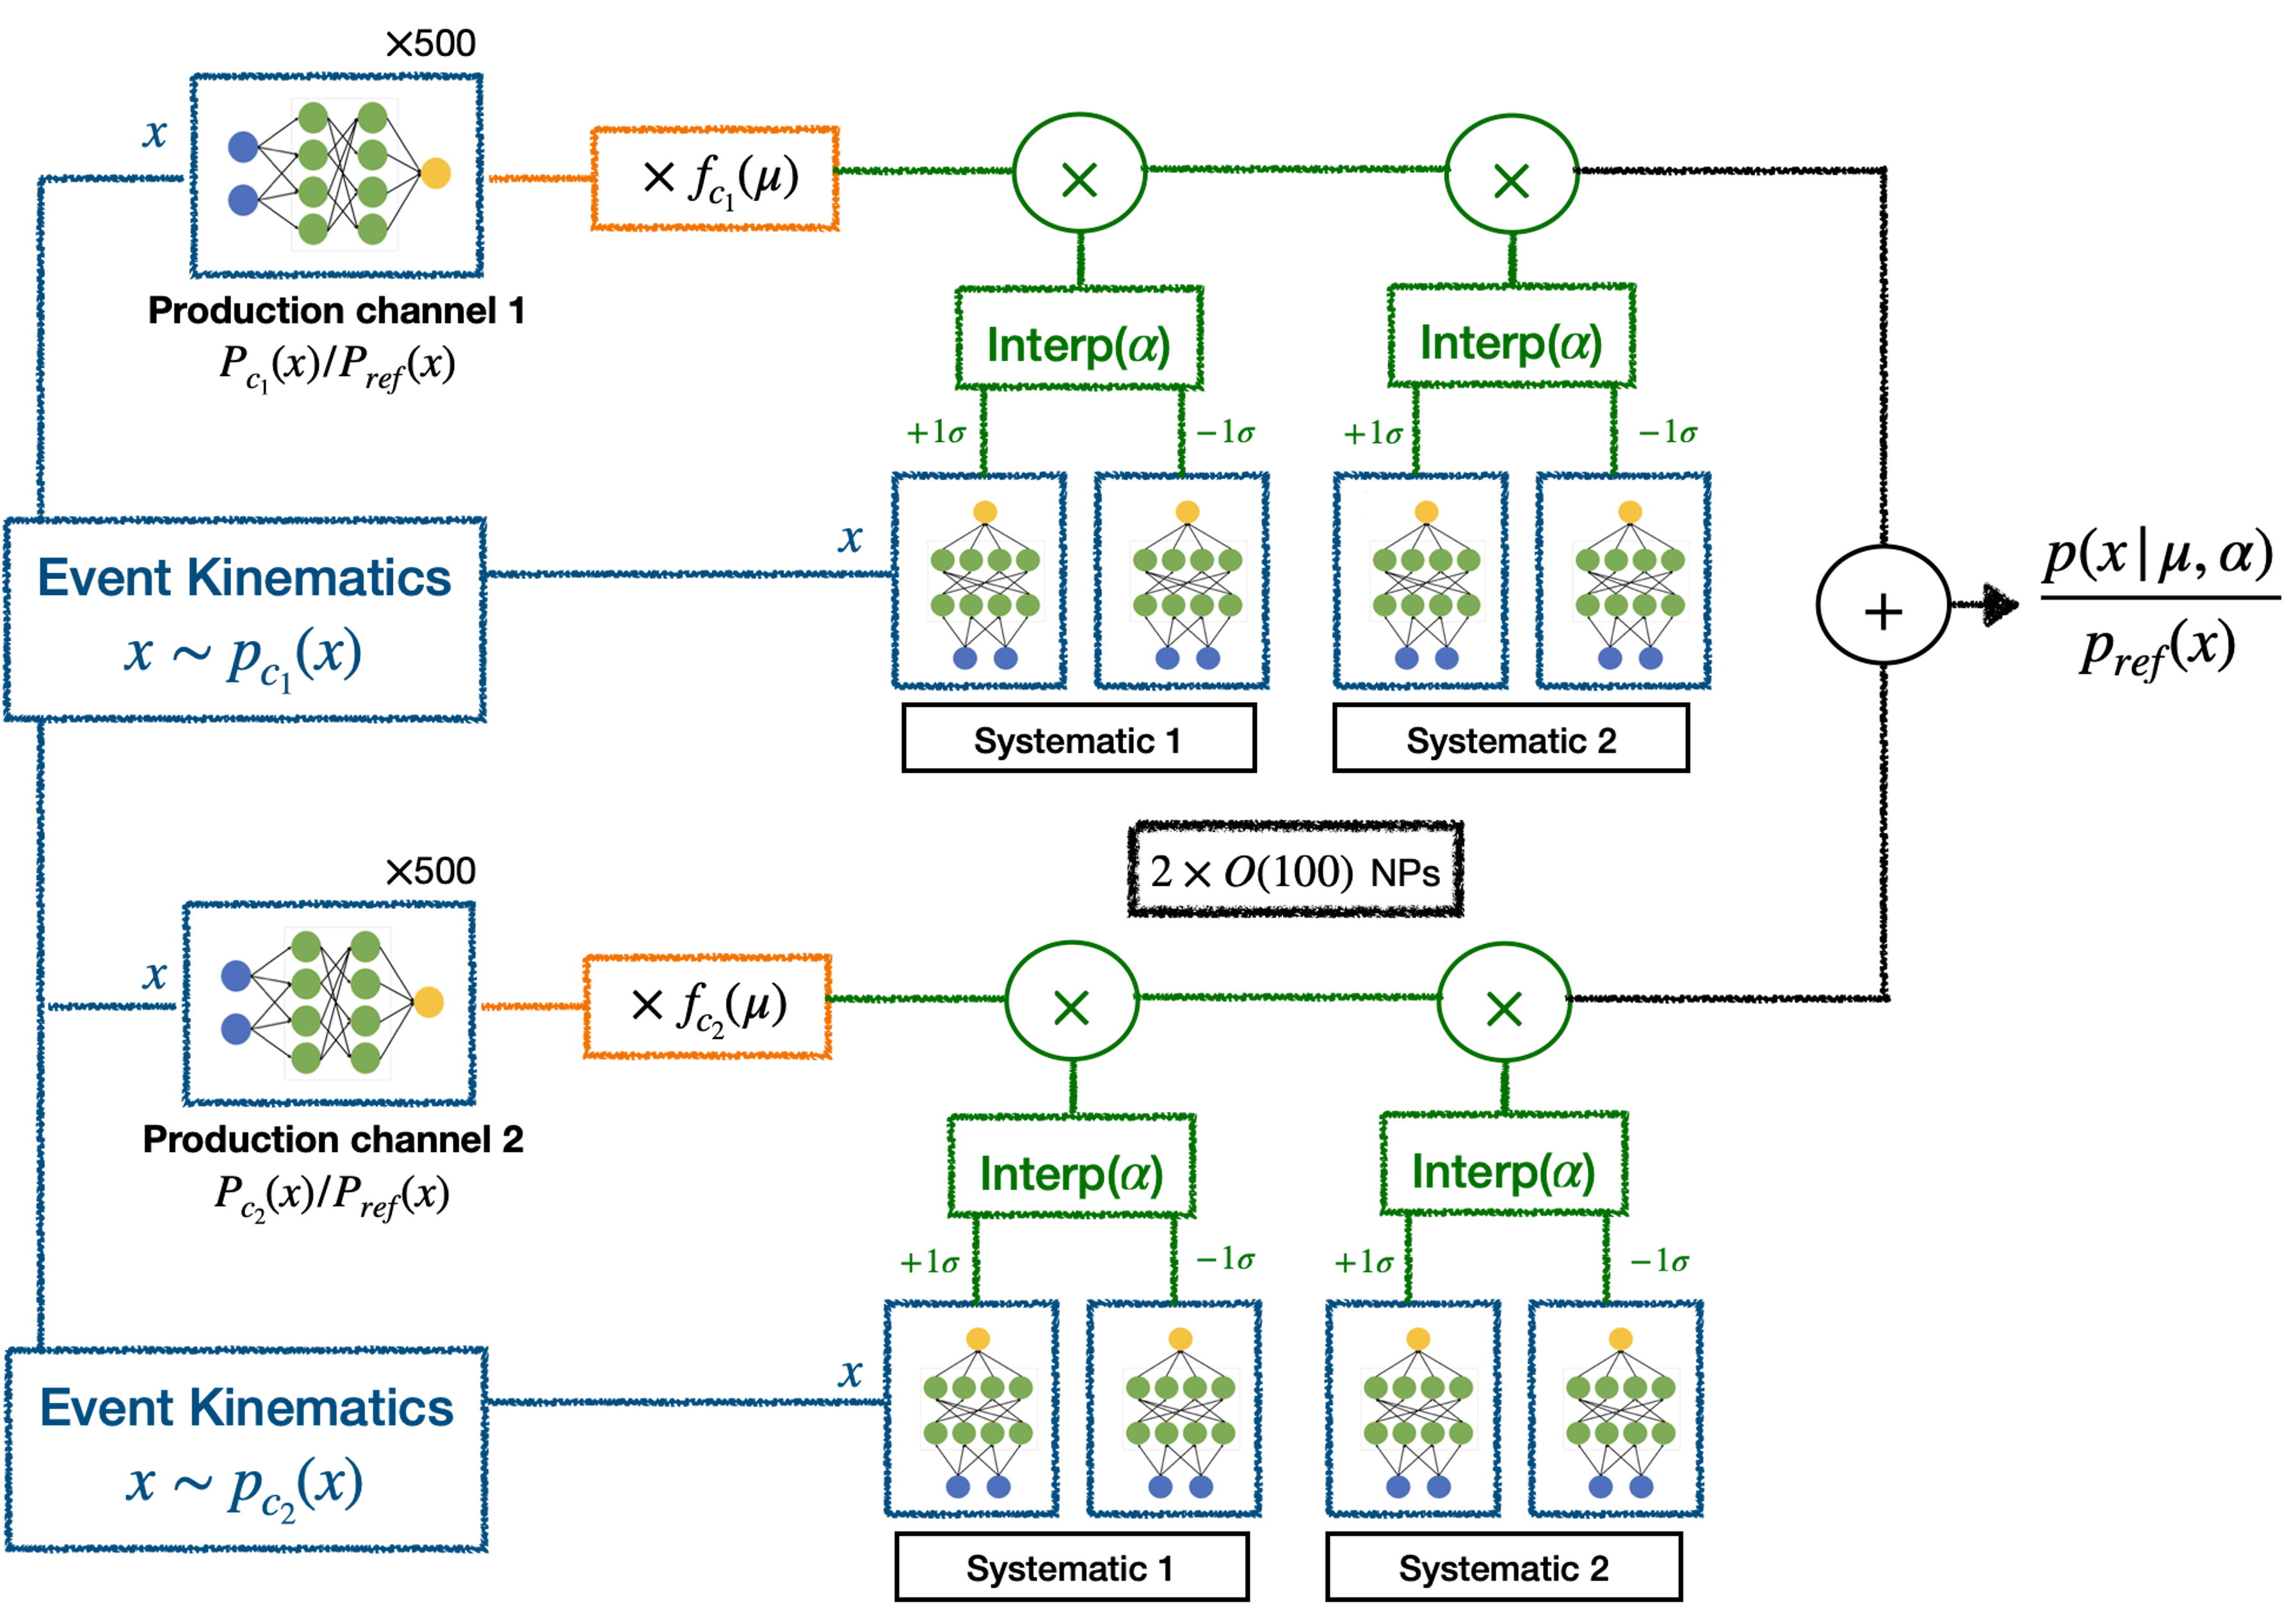

In [16]:
import os, sys, importlib
sys.path.append('../')

import common_utils
from common_utils import plotting, training
from common_utils.training import TrainEvaluate_NN, TrainEvaluatePreselNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
import pickle

from coffea.analysis_tools import PackedSelection

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

hep.style.use(hep.style.ATLAS)

In [38]:
# Load the datasets from pre-processed input
saved_data='./cached_data/'

syst_labels = np.load(f"{saved_data}syst_labels.npy")
training_features = np.load(f"{saved_data}features.npy")
train_labels = np.load(f"{saved_data}train_labels.npy")
weights = np.load(f"{saved_data}weights.npy")

# List of systematics to include
list_syst = ['ttbar_scale']

# Which samples are affected by which systematics
dict_systs = {'ttbar_scale': ['ttbar']}

list_syst = [key for key in dict_systs]


In [62]:
np.unique(syst_labels)

array(['ME_var', 'PS_var', 'nominal', 'pt_res_up', 'pt_scale_up',
       'ttbar_scale_down', 'ttbar_scale_up'], dtype='<U16')

In [39]:
# Keep only a subset of the background for illustration
labels_dict = {"ttbar": 0,              # signal process
              "single_top_t_chan":1, 
              "wjets":2}

# Uncomment below for a full analysis with all backgrounds
# labels_dict = {"ttbar": 0,
#                "single_top_s_chan":1,
#               "single_top_t_chan":2,
#               "single_top_tW":3,
#               "wjets":4}

In [40]:
type_vec = np.array(train_labels, dtype='object')

for key in labels_dict:
    type_vec[type_vec==labels_dict[key]] = key


In [41]:
# Build a pandas dataframe from the arrays for density ratio training and validation
# columns = ['lepton_pt', 'lepton_eta', 'lepton_phi']
columns = ['lepton_pt', 'lepton_eta', 'lepton_phi', 'H_T', 'n_jets']
dataset_incl = pd.DataFrame(training_features, columns=columns)

# Some scaling to reduce the spread of pt distributions 
dataset_incl['log_lepton_pt'] = np.log(dataset_incl['lepton_pt'].ravel())
dataset_incl['log_H_T'] = np.log(dataset_incl['H_T'].ravel())
dataset_incl['type'] = type_vec
dataset_incl['syst_labels'] = syst_labels
dataset_incl['weights'] = weights

Preselecting the systematics samples
===

In [42]:
# Only use lepton kinematics - use log pT for reduced spread
columns = ['log_lepton_pt', 'lepton_eta', 'lepton_phi', 'H_T', 'n_jets']
columns_scaling = ['log_lepton_pt', 'lepton_eta', 'lepton_phi', 'H_T']

# # Use lepton kinematics and the sum of jet pT observable 
# columns = ['log_lepton_pt', 'log_H_T', 'lepton_eta', 'lepton_phi']
# columns_scaling = ['log_lepton_pt', 'log_H_T', 'lepton_eta', 'lepton_phi'] # Subset of features which need scaling

In [43]:
importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluatePreselNN

preselectionTraining = TrainEvaluatePreselNN(dataset_incl, columns, columns_scaling)

In [44]:
path_to_saved_presel_model = './preselection_saved_NN/'
USE_SAVED_MODEL_PRESEL=True

preselectionTraining.get_trained_model(path_to_saved_presel_model)

In [45]:
# Get predictions (softmax outputs)
pred_NN = preselectionTraining.predict(dataset_incl)

203270/203270 [==============================] - 119s 586us/step


In [46]:
# the preselection score as defined above - log(P_S/P_B)
presel_score = np.log(pred_NN[:, labels_dict["ttbar"]]/(pred_NN[:, labels_dict["single_top_t_chan"]] + pred_NN[:, labels_dict["wjets"]]))

In [47]:
# preselection cut - same as training notebook
preselection_cut_lower = -0.6 

Signal and Control Regions
===

Split the dataset into SR and CR - the SR needs additional density ratios to be trained, whereas the CR follows the standard procedure of template histogram building.

In [48]:
# Make the preselections - defined the Signal Region

dataset_incl['presel_score'] = presel_score

dataset_SR = dataset_incl[(dataset_incl.presel_score>=preselection_cut_lower)].copy()

# Uncomment the line below if an upper cut is also needed
# dataset = dataset_incl[(dataset_incl.presel_score>=preselection_cut_lower) & (dataset_incl.presel_score<=preselection_cut_upper)].copy()

# Additional selections - same as nominal training notebook
dataset_SR = dataset_SR[(dataset_SR.lepton_pt<=200.0)].copy()
dataset_SR = dataset_SR[(dataset_SR.H_T<=1000.0)].copy()


In [55]:
# Load the Control Region observable
with open(f"{saved_data}hist_CR_ttbar.pkl", "rb") as fp:
    hist_CR = pickle.load(fp)

dataset_CR = dataset_incl[(dataset_incl.presel_score < preselection_cut_lower)].copy()

# Build a summary observable for Control Region
num_bins = 5
min_presel_bin = -0.9
min_presel_bin = -7
max_presel_bin = preselection_cut_lower

bins = np.linspace(min_presel_bin, max_presel_bin, num = num_bins)

hist_var = {}
for syst in dict_systs:
    hist_var[syst] = {}
    for direction in ['up', 'down']:
        
        hist_var[syst][direction] = {}
        mask_syst = (dataset_CR.syst_labels==syst+'_'+direction)
        
        for process in labels_dict:

            if process not in dict_systs[syst]:
                hist_var[syst][direction][process] = np.ones_like(hist_CR[process])

            else:
                
                mask_syst_process = (dataset_CR.type==process) & mask_syst
                
                hist_var[syst][direction][process] = np.histogram(np.clip(dataset_CR[mask_syst_process]['presel_score'].ravel(), 
                                                                    min_presel_bin, max_presel_bin), 
                                                                    weights = dataset_CR[mask_syst_process]['weights'].ravel(),
                                                                    bins = bins)[0]/hist_CR[process]

print(hist_var)

{'ttbar_scale': {'up': {'ttbar': array([1.03828172, 0.95089622, 0.98982245, 0.97869558]), 'single_top_t_chan': array([1., 1., 1., 1.]), 'wjets': array([1., 1., 1., 1.])}, 'down': {'ttbar': array([0.99335628, 0.98459558, 1.0205619 , 1.04940696]), 'single_top_t_chan': array([1., 1., 1., 1.]), 'wjets': array([1., 1., 1., 1.])}}}


In [56]:
# Save the Control Region variation histogram
with open(f"{saved_data}hist_CR_variations.pkl", "wb") as fp:
    pickle.dump(hist_var, fp)

In [64]:
# Normalizing the training weights post preselection 
weights_normed      = dataset_SR['weights'].to_numpy().copy()
weights             = dataset_SR['weights'].to_numpy().copy()

for syst_sample in np.unique(syst_labels):

    mask_syst = dataset_SR.syst_labels==syst_sample
    
    for key in labels_dict:

        mask_syst_process                     = mask_syst & dataset_SR.type==key
        weights_normed[mask_syst_process]    /= weights[mask_syst_process].sum()

dataset_SR['weights_normed'] = weights_normed

Density ratio training
===

Now we train the NNs for $\frac{p_c}{p_{ref}}(x)$ density ratios to build the full model. Our choice of reference hypothesis, motivated by the search-oriented mixture model described above, is: 

$$p_{ref}(x) = p_\text{ttbar}(x) = \frac{1}{\nu_\text{ttbar}} \frac{d\sigma_\text{ttbar}}{dx} $$

gives the POI $\mu-$parameterized model:

$$\sum_c \left[f_c(\mu) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)} \right]= \mu + \frac{p_\text{wjets}\left(x\right)}{p_\text{ttbar}(x)} + \frac{p_\text{single top}\left(x\right)}{p_\text{ttbar}(x)}$$

The task of estimating the $\mu-$parameterized density ratio is thus reduced to estimating two $\mu-$independent density ratios $\frac{p_\text{single top}}{p_{t\bar{t}}}(x)$ and $\frac{p_\text{wjets}}{p_{t\bar{t}}}(x)$ mixed together with an analytical parameterization (hence the name mixture model).

In [18]:
importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluate_NN

mix_model_hypotheses = ['wjets', 'single_top_t_chan']
ref_processes = ['ttbar']
mask_ref = np.isin(dataset.type, ref_processes)

dataset_mix_model = {}
NN_training_mix_model = {}

rnd_seed_traintestsplit = 42 # can also be randomized, fixed for now

for process_type in mix_model_hypotheses:
    
    mask_process = dataset['type']==process_type
    
    # Build a training dataset for the training of p_<process_type>/p_<ref_processes> density ratio
    dataset_mix_model[process_type] = pd.concat([dataset[mask_process].copy(), 
                                                      dataset[mask_ref].copy()])

    mask_ref_mix_model = np.isin(dataset_mix_model[process_type].type, ref_processes)
    dataset_mix_model[process_type]['train_labels'] = 0
    dataset_mix_model[process_type].loc[mask_ref_mix_model, 'train_labels'] = 1

    # Save paths
    top_path = f'./output_training_nominal/'
    output_name = f'{process_type}'
    output_dir = f'{top_path}general_output_{process_type}'
    path_to_ratios = f'{top_path}output_ratios_{process_type}/'
    path_to_figures = f'{top_path}output_figures_{process_type}/'
    path_to_models = f'{top_path}output_model_params_{process_type}/'

    NN_training_mix_model[process_type] = TrainEvaluate_NN(dataset_mix_model[process_type], 
                                                           dataset_mix_model[process_type]['weights_normed'],
                                                           dataset_mix_model[process_type]['train_labels'],
                                                           columns, 
                                                           columns_scaling, rnd_seed_traintestsplit,
                                                           [process_type, 'ref'], output_dir, output_name, 
                                                            path_to_figures=path_to_figures,
                                                            path_to_ratios=path_to_ratios, 
                                                            path_to_models=path_to_models)





Neural Network architecture
===

Here we will start with a multi-layer perceptron (simple feed-forward Neural Network with fully-connected layers). This can be supplemented with more complex architectures like transformers. 

After detailed tuning during the off-shell Higgs boson analysis effort, we found that a network with very wide layers ($\geq 1000$) and a depth of less than 10 works best - alongside batch size of a few hundreds and a gradually declining learning rate that starts with a value just large enough to not blow up.

Starting with the training and validation of the wjets density ratio:

$$\frac{p_\text{wjets}(x)}{p_\text{ttbar}(x)}$$

Sum of weights of class 0: 0.8000176273576592
Sum of weights of class 1: 0.8000000000000012
Using swish activation function
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              6000      
                                                                 
 dense_1 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_2 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 1008001 (3.85 MB)
Trainable params: 1008001 (3.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Using Callbacks
Epoch 1/70


2025-04-18 09:55:03.021791: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd3107d1d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-18 09:55:03.021848: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-04-18 09:55:03.030655: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-18 09:55:03.047468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2025-04-18 09:55:03.108726: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-18 09:55:03.171010: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


687/687 - 3s - loss: 2.2322e-06 - binary_accuracy: 0.7325 - val_loss: 2.7102e-06 - val_binary_accuracy: 0.6496 - lr: 0.1000 - 3s/epoch - 5ms/step
Epoch 2/70
687/687 - 1s - loss: 2.1638e-06 - binary_accuracy: 0.7457 - val_loss: 3.0215e-06 - val_binary_accuracy: 0.5895 - lr: 0.1000 - 1s/epoch - 2ms/step
Epoch 3/70
687/687 - 1s - loss: 2.1814e-06 - binary_accuracy: 0.7449 - val_loss: 2.3656e-06 - val_binary_accuracy: 0.7006 - lr: 0.1000 - 1s/epoch - 2ms/step
Epoch 4/70
687/687 - 1s - loss: 2.1496e-06 - binary_accuracy: 0.7479 - val_loss: 2.1865e-06 - val_binary_accuracy: 0.7414 - lr: 0.1000 - 1s/epoch - 2ms/step
Epoch 5/70
687/687 - 1s - loss: 2.1468e-06 - binary_accuracy: 0.7477 - val_loss: 2.9370e-06 - val_binary_accuracy: 0.7005 - lr: 0.1000 - 1s/epoch - 2ms/step
Epoch 6/70
687/687 - 1s - loss: 2.1463e-06 - binary_accuracy: 0.7488 - val_loss: 2.3393e-06 - val_binary_accuracy: 0.7322 - lr: 0.1000 - 1s/epoch - 2ms/step
Epoch 7/70
687/687 - 1s - loss: 2.1443e-06 - binary_accuracy: 0.7493 

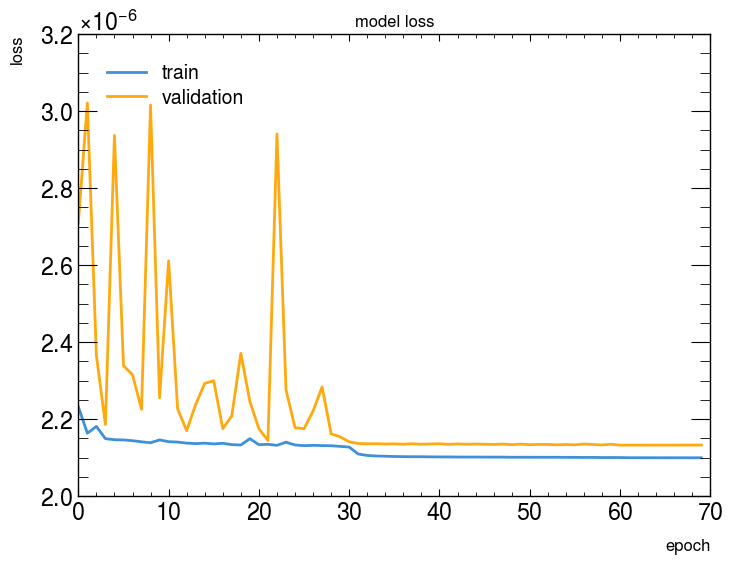

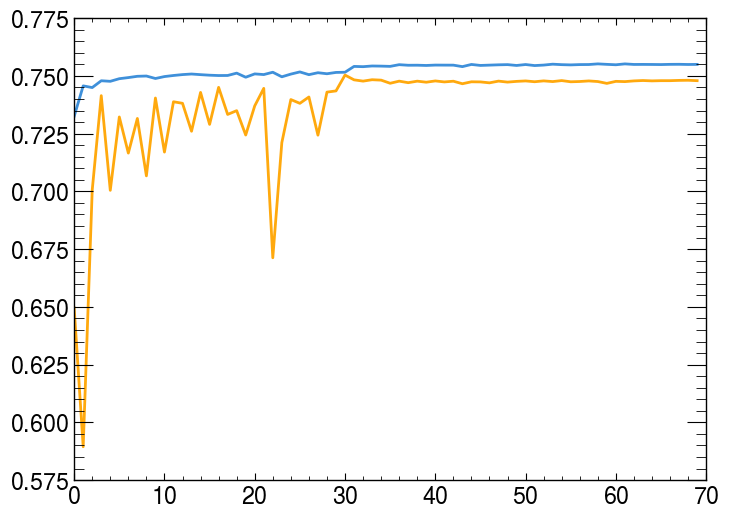

3049/3049 - 2s - 2s/epoch - 630us/step
12197/12197 - 7s - 7s/epoch - 590us/step


<Figure size 800x600 with 0 Axes>

In [19]:
# Train the density ratio NN
NN_training_mix_model['wjets'].train (   hidden_layers        = 2, 
                                         neurons              = 1000, 
                                         number_of_epochs     = 70, 
                                         batch_size           = 512, 
                                         learning_rate        = 0.1, 
                                         scalerType           = 'MinMax', 
                                         calibration          = False, 
                                         num_bins_cal         = 10, 
                                         callback             = True, 
                                         callback_patience    = 30, 
                                         callback_factor      = 0.01     )    


Check for overtraining by comparing the NN output distributions between training and holdout datasets. The holdout dataset is the subset of events not used during training.

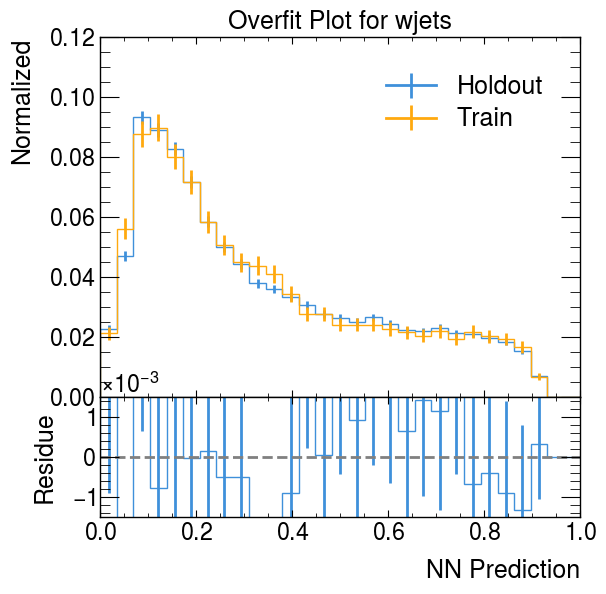

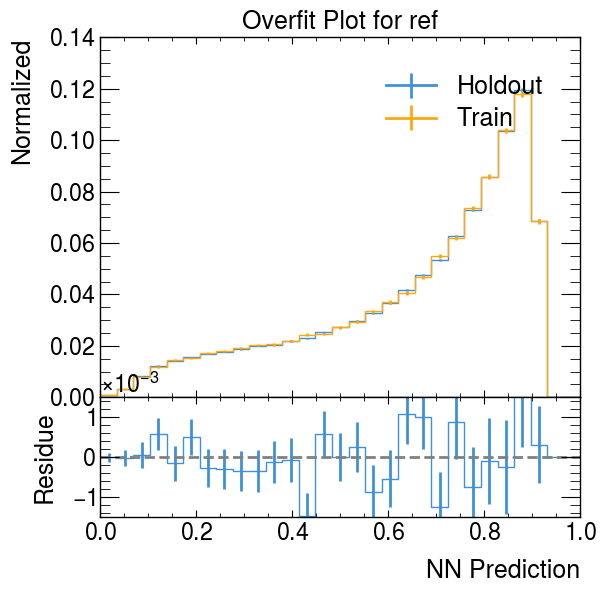

<Figure size 800x600 with 0 Axes>

In [20]:
NN_training_mix_model['wjets'].make_overfit_plots()

Diagnostic Checks
===

While traditionally, a NN observable is judged on the basis of its accuracy - for NSBI we are interested in the quality of the density ratios more than the discrimination power. The latter comes from the perfect modelling of the multi-dimensional likelihood ratios.

To ensure correct modelling, we run two main checks on the training:

- **Calibration closure test**

  The NNs are trained using the binary cross-entropy loss, which under ideal conditions leads to the NN converging to the score function:

  $$\hat{s}_\text{pred} = \frac{p_\text{ttbar}(x)}{p_\text{ttbar}(x)+p_\text{wjets}(x)}$$

  that can be converted into the probability ratio we desire (likelihood ratio trick):

  $$\frac{p_\text{wjets}(x)}{p_\text{ttbar}(x)} = \frac{\hat{s}_\text{pred}(x)}{1-\hat{s}_\text{pred}(x)}$$

  For the NNs to be well-calibrated, we use the Monte Carlo samples to verify the equality:


  $$\left[\frac{p_c(x)}{p_c(x)+p_{ref}(x)}\right]_\text{NN} \sim \left[\frac{\mathcal{N}_c^{I(x|\hat{s}_\text{pred})}}{\mathcal{N}_c^{I(x|\hat{s}_\text{pred})}+\mathcal{N}_\text{ref}^{I(x|\hat{s}_\text{pred})}}\right]_\text{MC}$$

  where we bin the events from $p_c$ and $p_\text{ref}$ MC samples, denoted by $\mathcal{N}_c^{I(x|\hat{s}_\text{pred})}$ and $\mathcal{N}_\text{ref}^{I(x|\hat{s}_\text{pred})}$ respectively where $I(x|\hat{s}_\text{pred})$ returns the index of the $\hat{s}_\text{pred}$ bin in which an event $x$ falls.
 


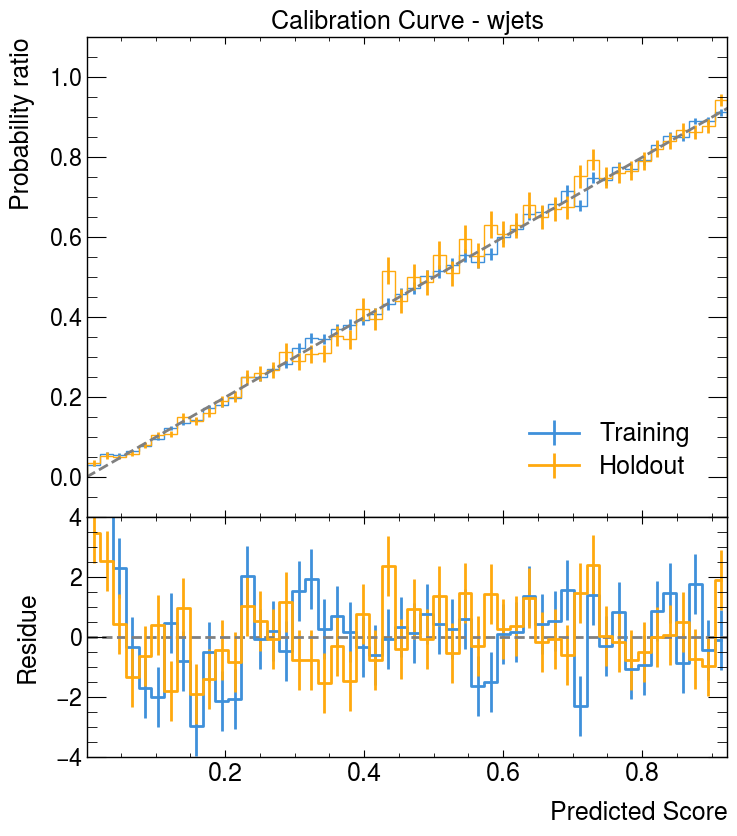

observable not recognized


<Figure size 800x600 with 0 Axes>

In [21]:
num_bins_cal = 50
NN_training_mix_model['wjets'].make_calib_plots(nbins=num_bins_cal, observable='score')

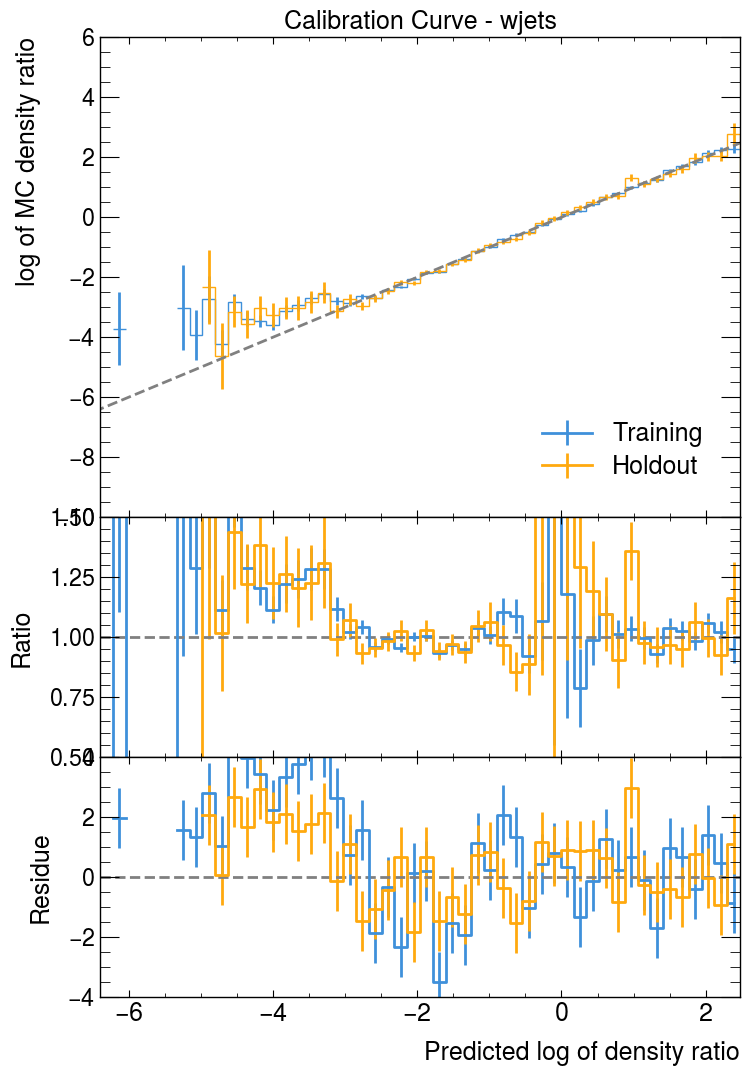

<Figure size 800x600 with 0 Axes>

In [22]:
num_bins_cal = 50
NN_training_mix_model['wjets'].make_calib_plots(nbins=num_bins_cal, observable='llr')

- **Density ratio reweighting closure tests**
  
  Despite having a well-calibrated output and thus a robust probabilistic interpretation, the trained density ratios might not capture the full multi-dimensional event information $x$. In other words, the NNs might still be biased estimators of the optimal score function, as defined in the CARL paper (link).

  The next diagnostic involves verifying the following equality using 1D projections of $x$:

  $$\frac{p_c(x)}{p_{ref}(x)} \times p_{ref}(x) \sim p_c(x)$$

  We can do this one-by-one for all the observables used to model the density ratios, and also possibly the observables not used directly in the training but can still be well-estimated due to the NN learning the right physics.

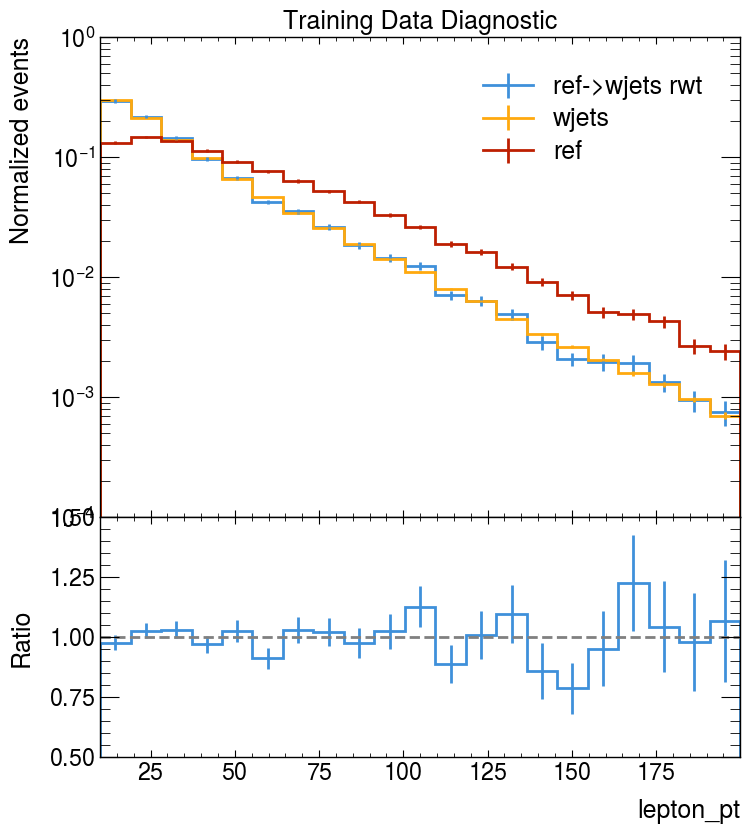

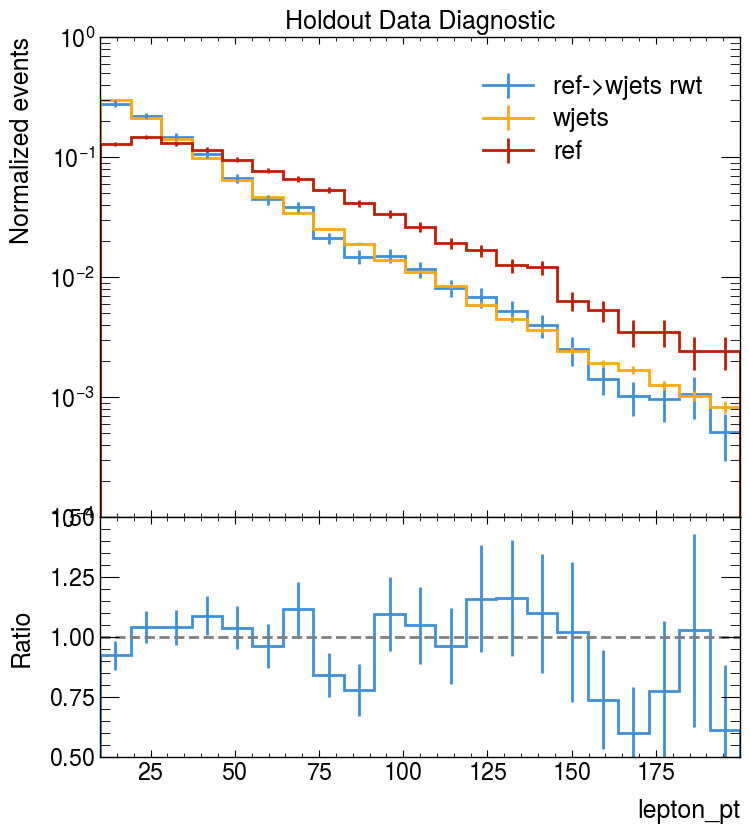

<Figure size 800x600 with 0 Axes>

In [23]:
variables_to_plot=['lepton_pt'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_mix_model['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


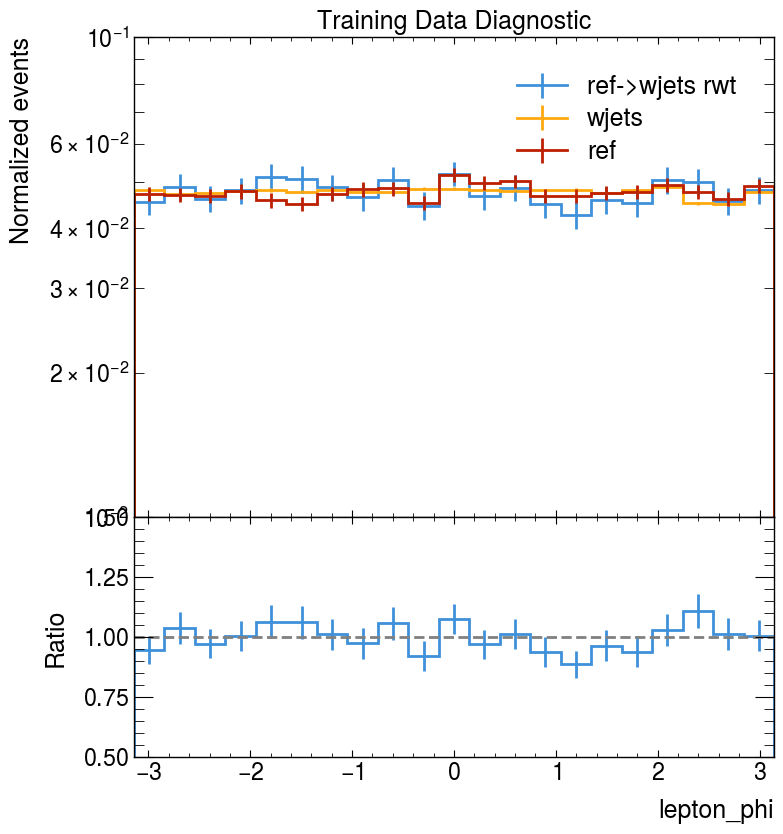

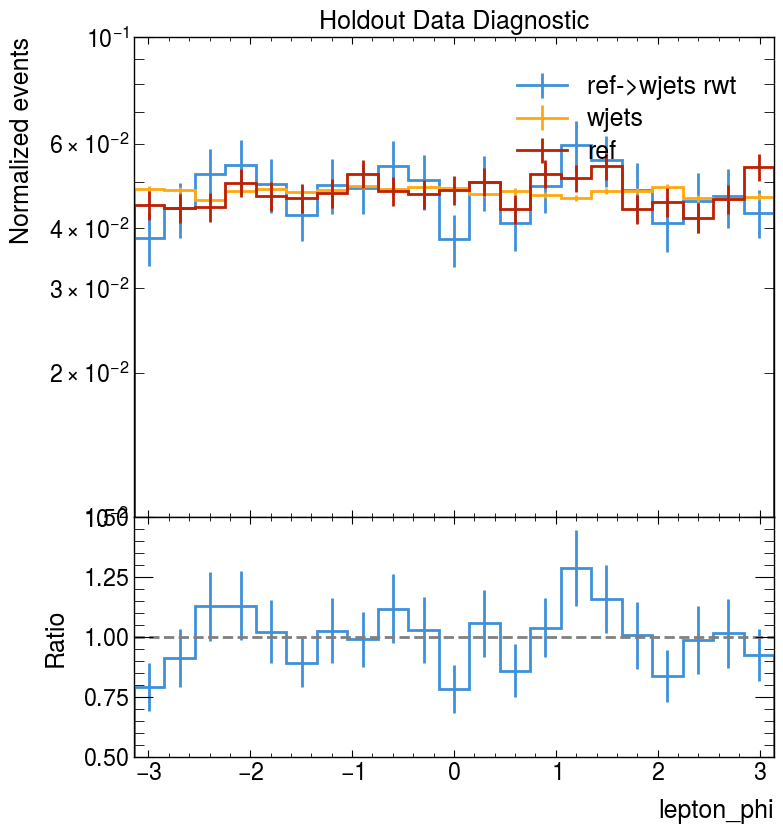

<Figure size 800x600 with 0 Axes>

In [24]:
variables_to_plot=['lepton_phi']
yscale_type='log'
num_bins_plotting=21

NN_training_mix_model['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


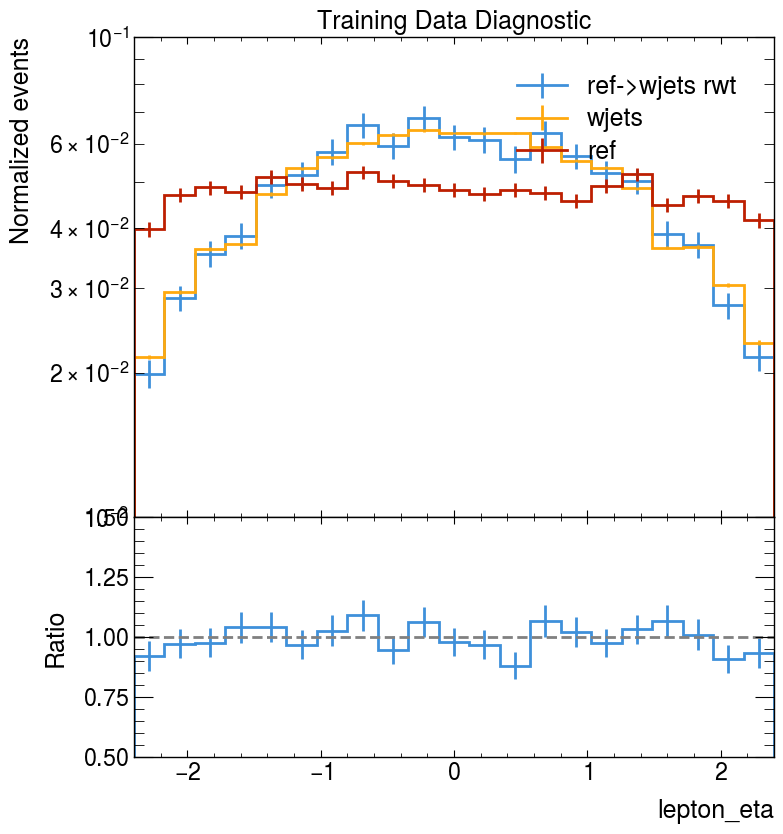

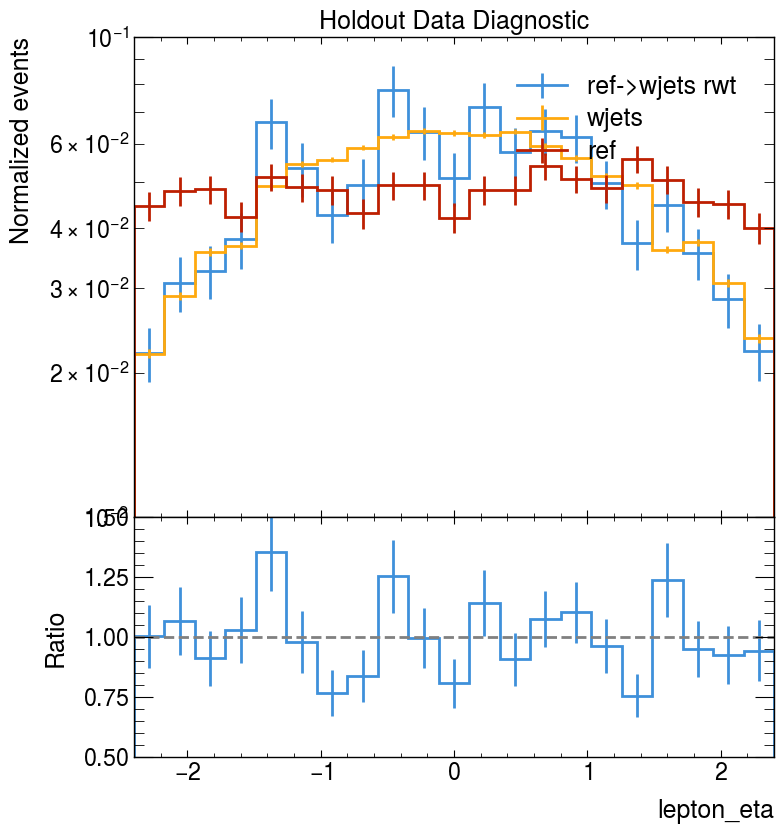

<Figure size 800x600 with 0 Axes>

In [25]:
variables_to_plot=['lepton_eta']
yscale_type='log'
num_bins_plotting=21

NN_training_mix_model['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


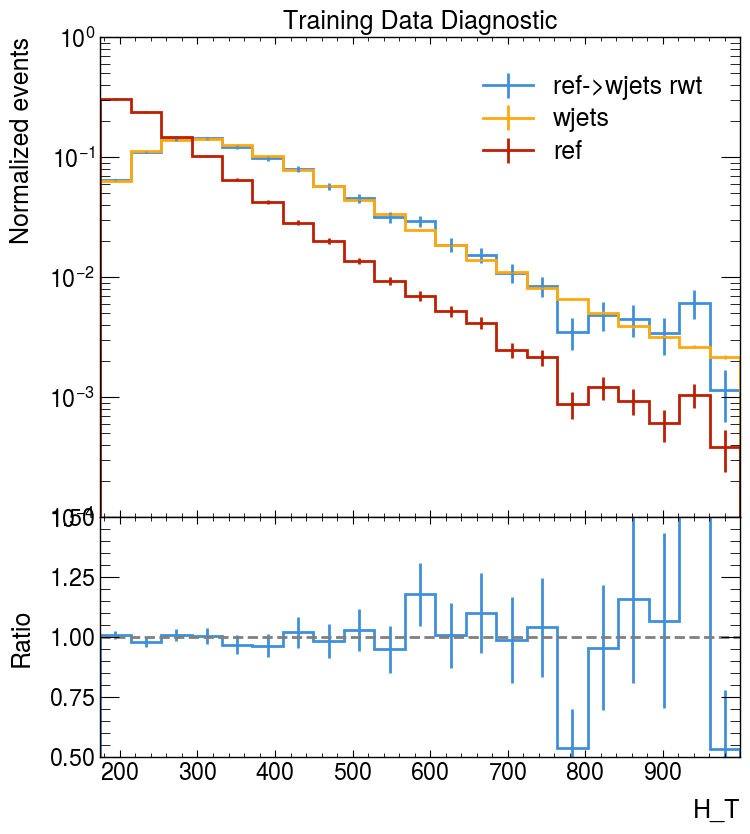

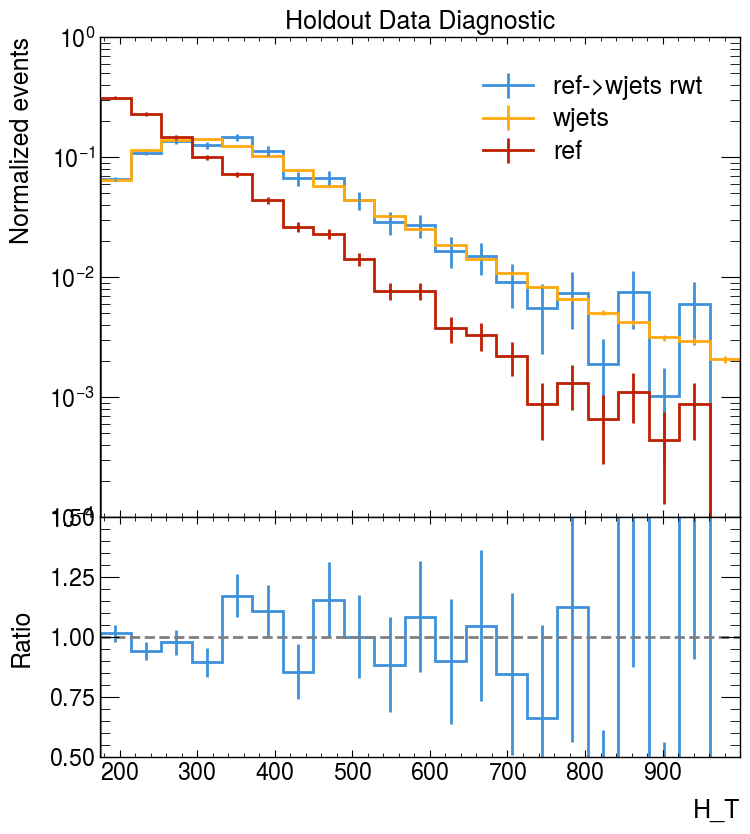

<Figure size 800x600 with 0 Axes>

In [26]:
variables_to_plot=['H_T']
yscale_type='log'
num_bins_plotting=21

NN_training_mix_model['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


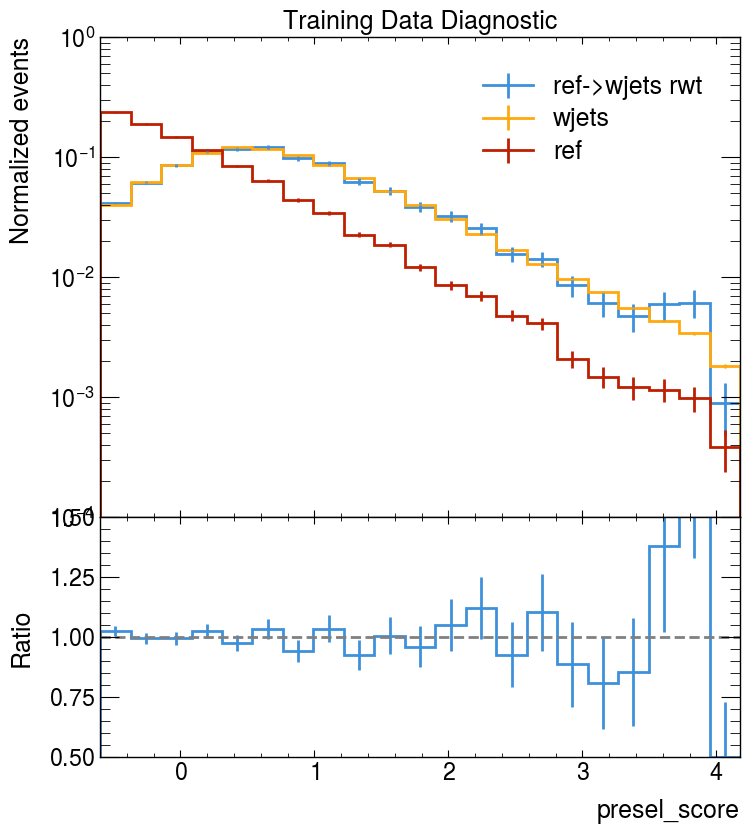

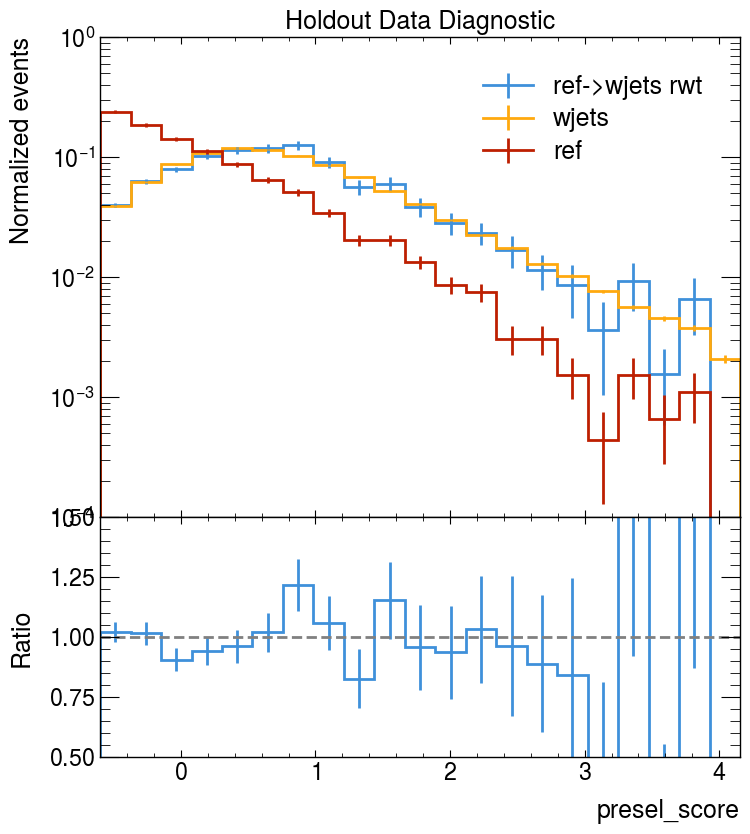

<Figure size 800x600 with 0 Axes>

In [27]:
variables_to_plot=['presel_score']
yscale_type='log'
num_bins_plotting=21

NN_training_mix_model['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [28]:
# Evaluate the density ratios p_wjets/p_ttbar for the full dataset and save for the inference step
NN_training_mix_model['wjets'].evaluate_and_save_ratios(dataset)

21172/21172 - 12s - 12s/epoch - 570us/step


Now for the training and validation of the other density ratio:

$$\frac{p_\text{single top}(x)}{p_\text{ttbar}(x)}$$

Sum of weights of class 0: 0.8000031636726019
Sum of weights of class 1: 0.8000000000000012
Using swish activation function
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1000)              6000      
                                                                 
 dense_4 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_5 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 1008001 (3.85 MB)
Trainable params: 1008001 (3.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Using Callbacks
Epoch 1/70
921/921 - 3s - loss: 1.9497e-06 - binary_accuracy: 0.6439 - val_loss: 1.9311e-06 - val_binary_accuracy: 0.6516 - lr: 0.1000 - 3s/

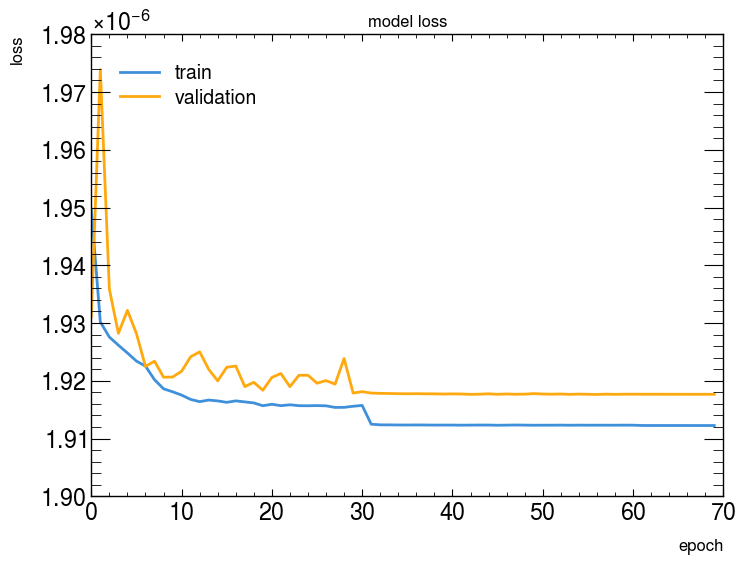

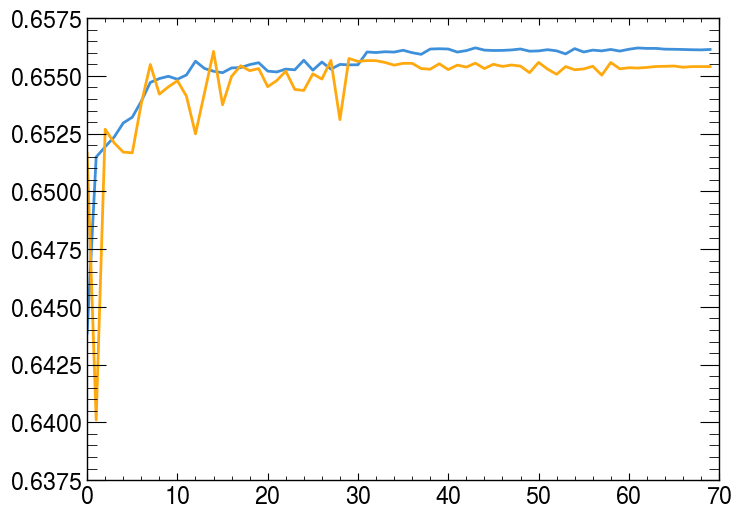

4093/4093 - 2s - 2s/epoch - 584us/step
16371/16371 - 9s - 9s/epoch - 580us/step


<Figure size 800x600 with 0 Axes>

In [29]:
# Train the density ratio NN
NN_training_mix_model['single_top_t_chan'].train (   hidden_layers        = 2, 
                                                     neurons              = 1000, 
                                                     number_of_epochs     = 70, 
                                                     batch_size           = 512, 
                                                     learning_rate        = 0.1, 
                                                     scalerType           = 'MinMax', 
                                                     calibration          = False, 
                                                     num_bins_cal         = 10, 
                                                     callback             = True, 
                                                     callback_patience    = 30, 
                                                     callback_factor      = 0.01     )    


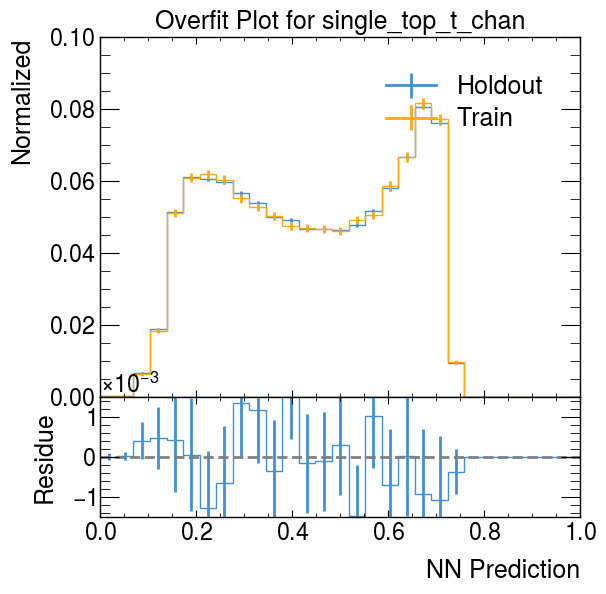

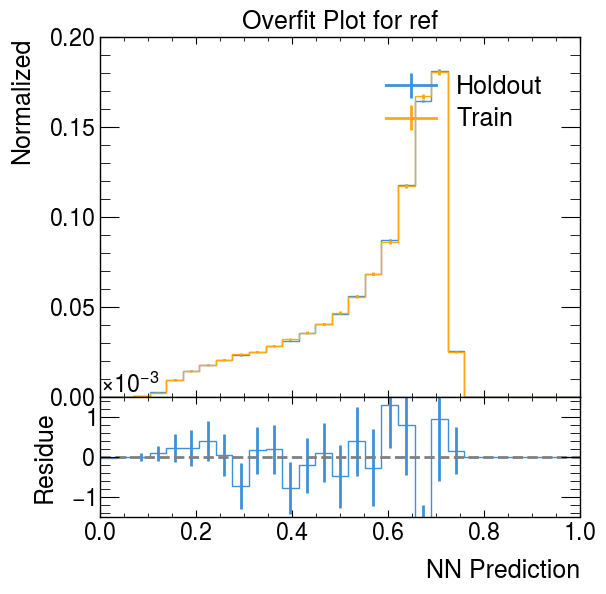

<Figure size 800x600 with 0 Axes>

In [30]:
NN_training_mix_model['single_top_t_chan'].make_overfit_plots()

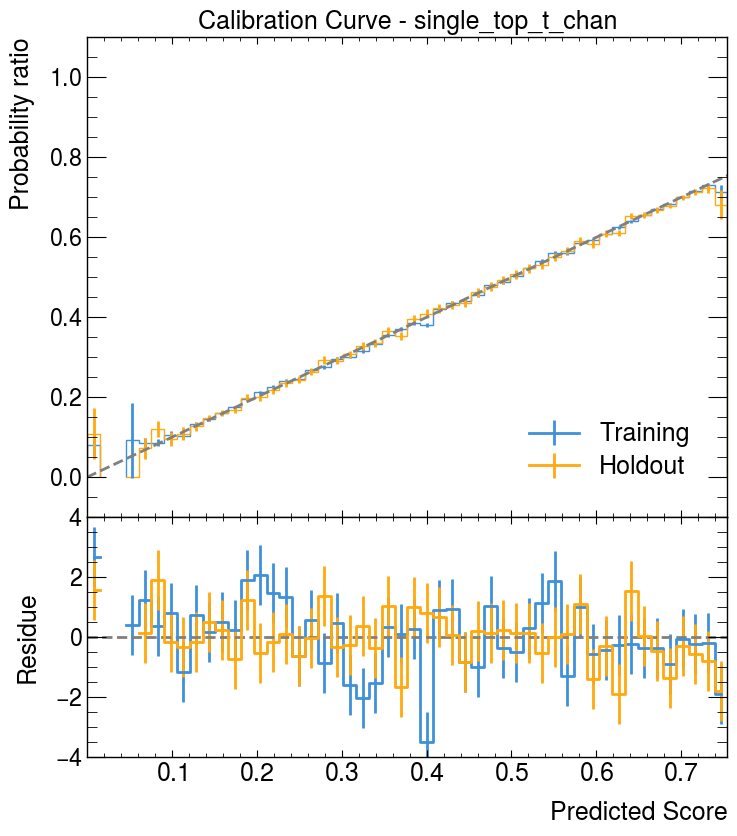

observable not recognized


<Figure size 800x600 with 0 Axes>

In [31]:
num_bins_cal = 50
NN_training_mix_model['single_top_t_chan'].make_calib_plots(nbins=num_bins_cal, observable='score')

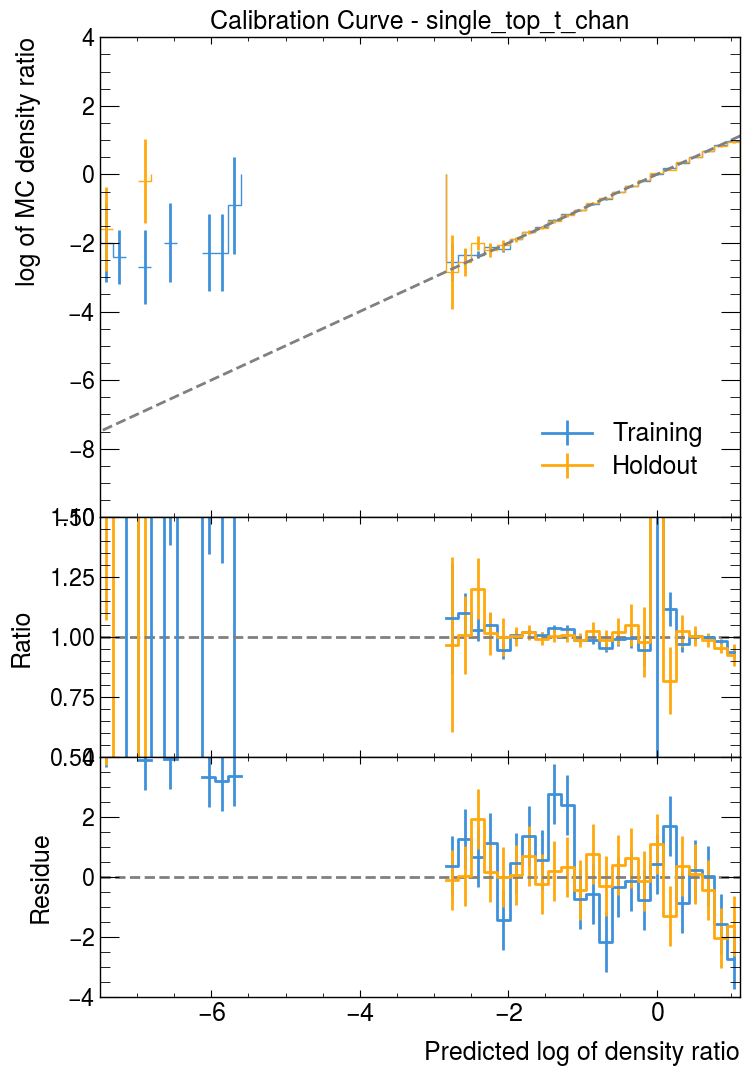

<Figure size 800x600 with 0 Axes>

In [32]:
NN_training_mix_model['single_top_t_chan'].make_calib_plots(nbins=num_bins_cal, observable='llr')


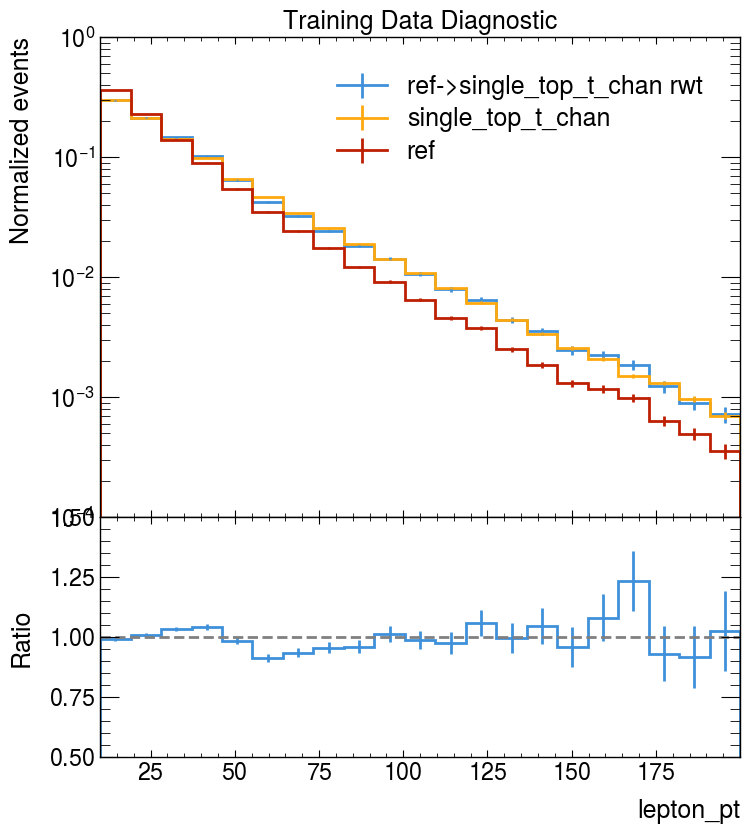

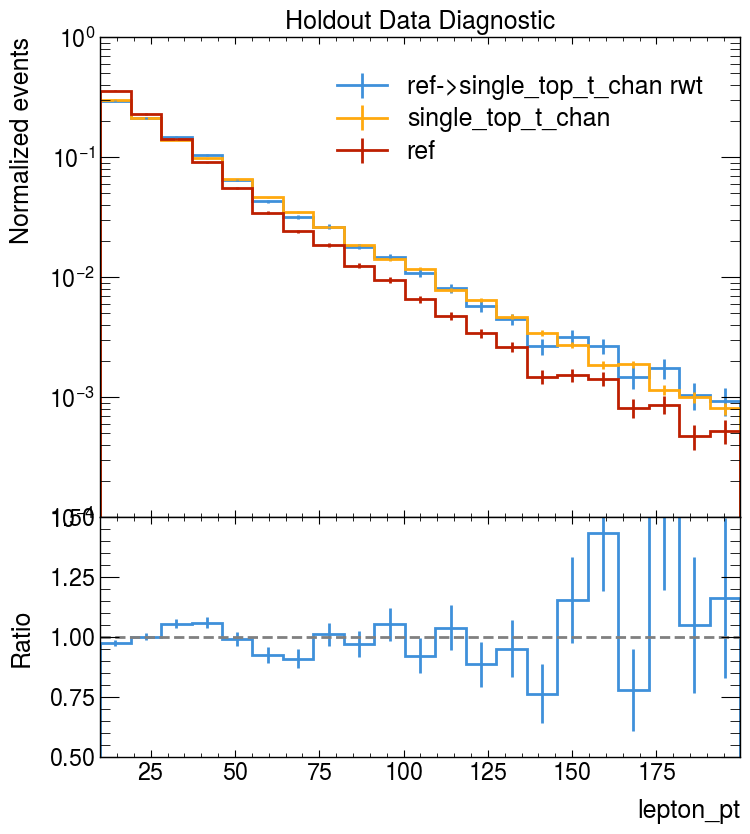

<Figure size 800x600 with 0 Axes>

In [33]:
variables_to_plot=['lepton_pt']
yscale_type='log'
num_bins_plotting=21

NN_training_mix_model['single_top_t_chan'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


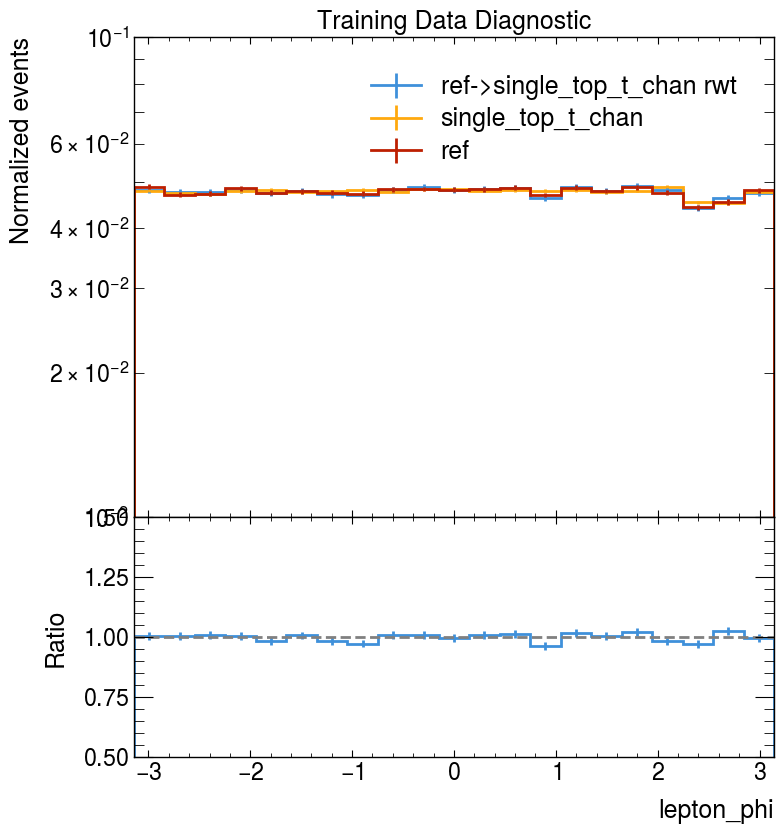

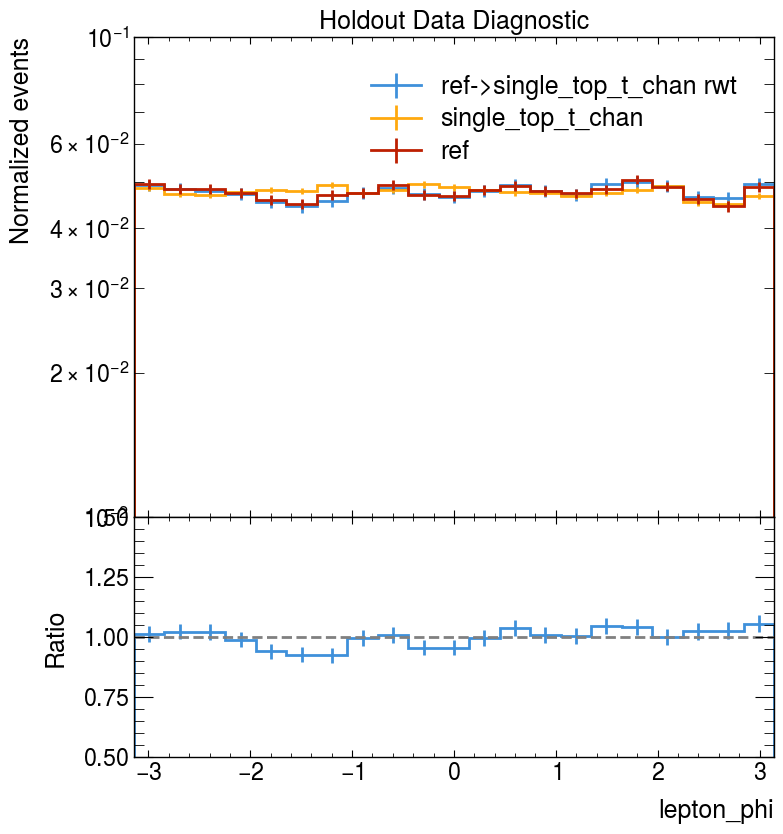

<Figure size 800x600 with 0 Axes>

In [34]:
variables_to_plot=['lepton_phi']
yscale_type='log'
num_bins_plotting=21

NN_training_mix_model['single_top_t_chan'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


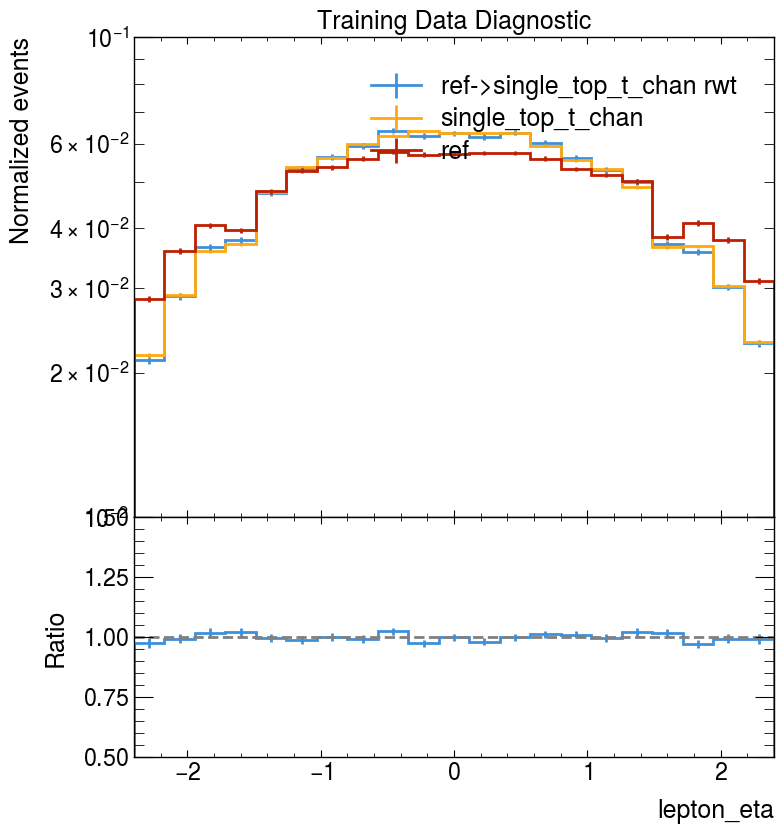

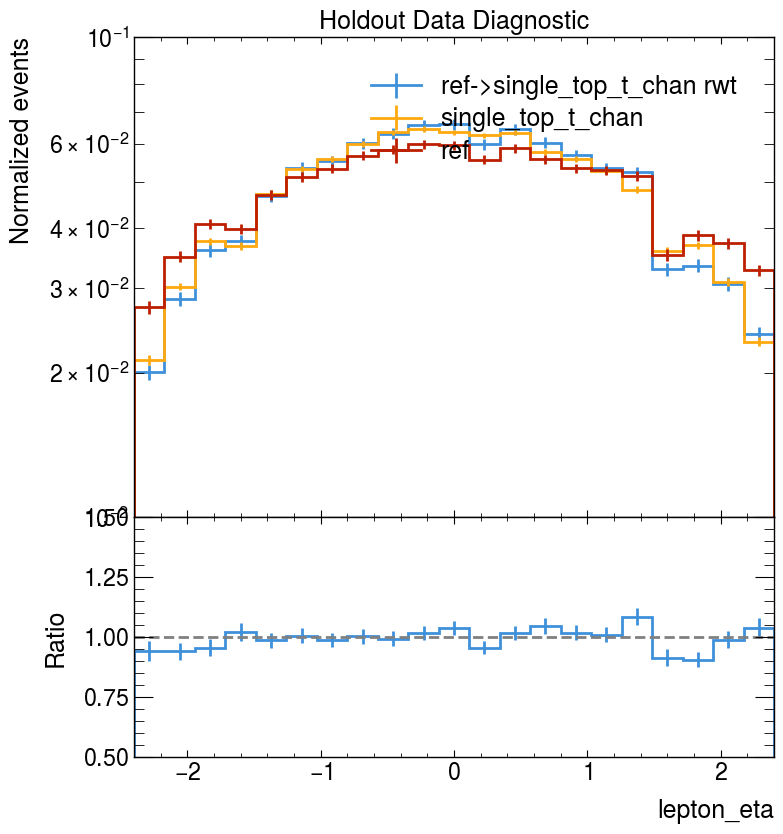

<Figure size 800x600 with 0 Axes>

In [35]:
variables_to_plot=['lepton_eta']
yscale_type='log'
num_bins_plotting=21

NN_training_mix_model['single_top_t_chan'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


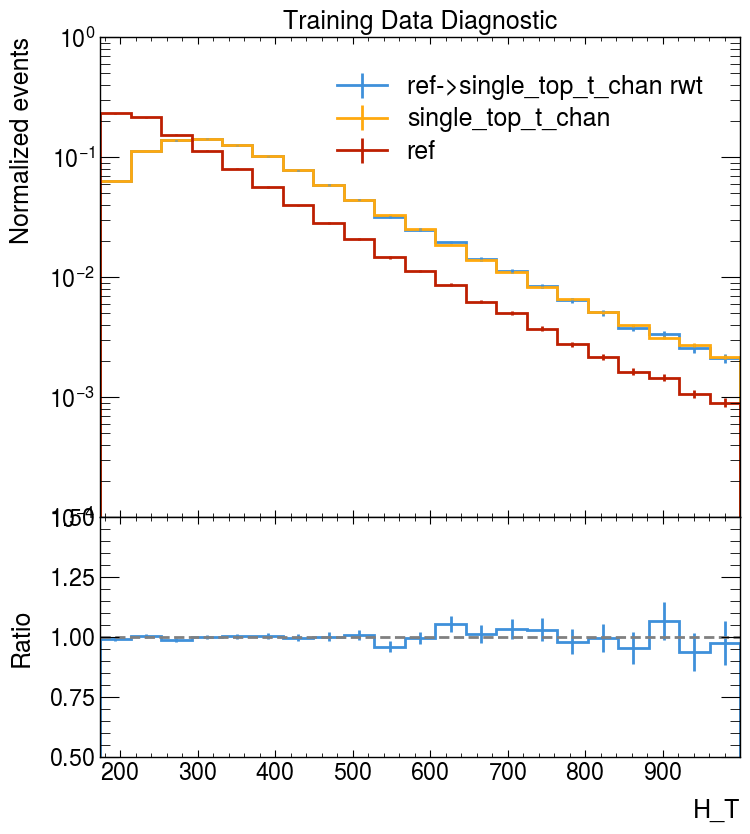

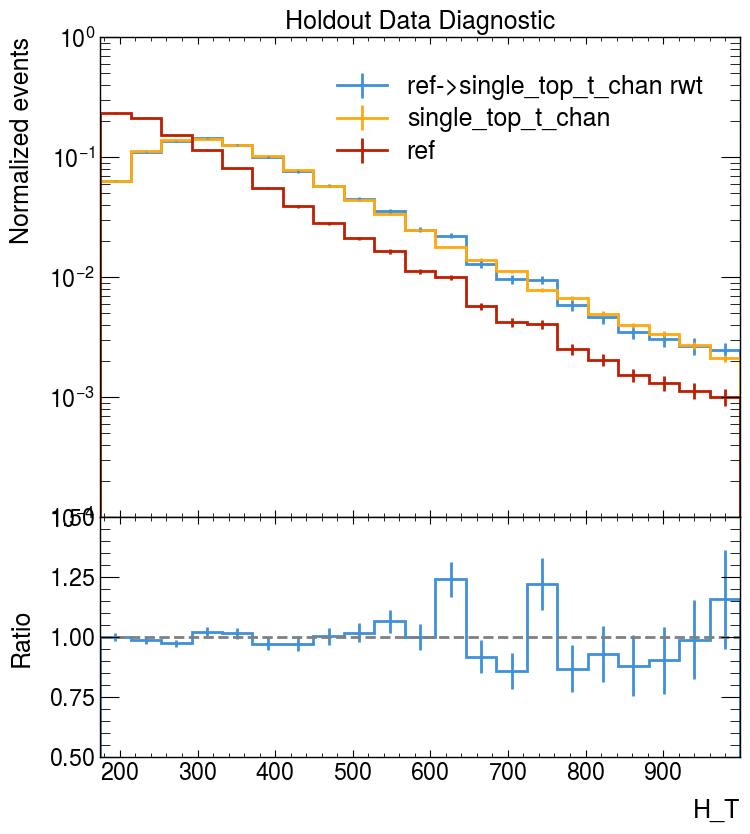

<Figure size 800x600 with 0 Axes>

In [36]:
variables_to_plot=['H_T']
yscale_type='log'
num_bins_plotting=21

NN_training_mix_model['single_top_t_chan'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


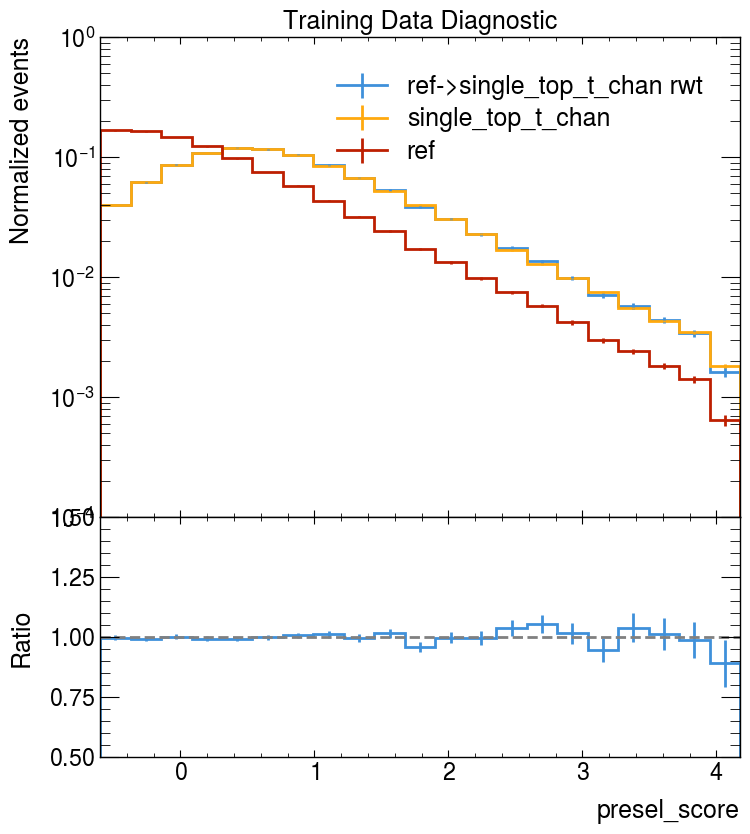

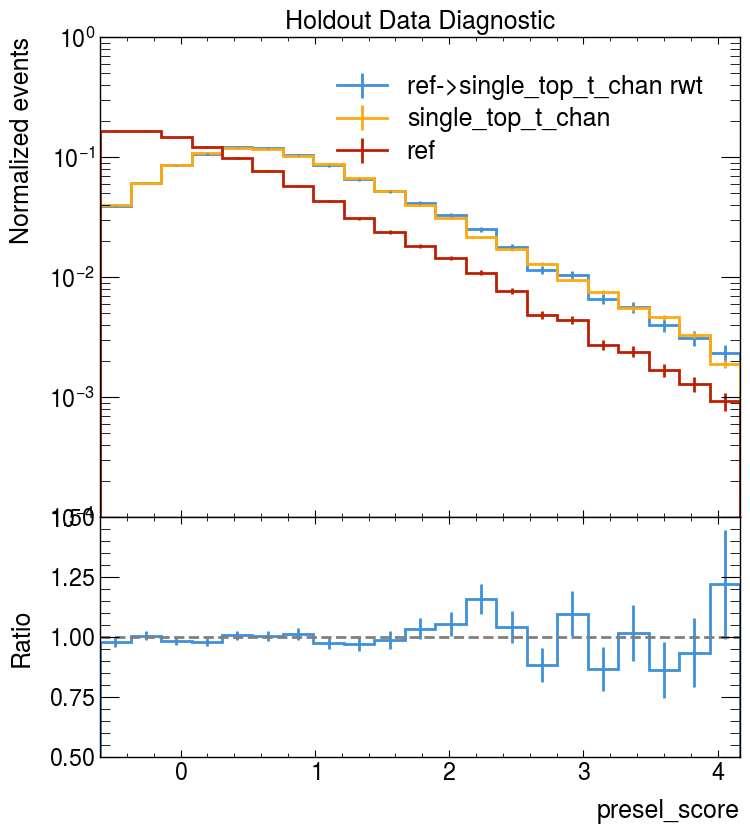

<Figure size 800x600 with 0 Axes>

In [37]:
variables_to_plot=['presel_score']
yscale_type='log'
num_bins_plotting=21

NN_training_mix_model['single_top_t_chan'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [38]:
# Evaluate the density ratios p_singletop/p_ttbar for the full dataset and save for the inference step
NN_training_mix_model['single_top_t_chan'].evaluate_and_save_ratios(dataset)

21172/21172 - 12s - 12s/epoch - 574us/step
